# Clustering Analysis – Students' Social Media Addiction
**Research question:**  
How are different patterns of social media usage associated with students’ sleep duration and mental health?
What are the patterns of students regarding social media? aalso in wlche katgroein siend die studenten unterteilbar regarding social media addiction?

**Definition:** Clustering groups students with similar characteristics together.  
In this analysis, it helps identify typical patterns in social media use, addiction, sleep, and well-being, so we can understand different types of students without assigning categories in advance.

**Goal:** Identify student segments (clusters) based on social media usage/addiction and related outcomes  
(e.g., sleep, mental health, relationship conflicts) using **K-Means**.

**Method overview:**
1. Load + explore dataset  
2. Select numeric features  
3. Scale features (center + standardize)  
4. Choose number of clusters (elbow plot)  
5. Fit K-Means and interpret cluster profiles

**Goal:** Identify student segments (clusters) based on social media usage/addiction and related outcomes  
(e.g., sleep, mental health, relationship conflicts) using **K-Means**.

**Method overview:**
1. Load + explore dataset  
2. Select numeric features  
3. Scale features (center + standardize)  
4. Choose number of clusters (elbow plot)  
5. Fit K-Means and interpret cluster profiles


1. Imports + load data

In [95]:
%pip install pandas seaborn matplotlib openpyxl
import pandas as pd
import seaborn as sns
import os
os.environ["OMP_NUM_THREADS"] = "3"
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

df = pd.read_csv("media_addiction.csv")  # or your filename
df.head()




Note: you may need to restart the kernel to use updated packages.


,Student_ID,Age,Gender,Academic_Level,Country,Avg_Daily_Usage_Hours,Most_Used_Platform,Affects_Academic_Performance,Sleep_Hours_Per_Night,Mental_Health_Score,Relationship_Status,Conflicts_Over_Social_Media,Addicted_Score
0,1,19,Female,Undergraduate,Bangladesh,5.2,Instagram,Yes,6.5,6,In Relationship,3,8
1,2,22,Male,Graduate,India,2.1,Twitter,No,7.5,8,Single,0,3
2,3,20,Female,Undergraduate,USA,6.0,TikTok,Yes,5.0,5,Complicated,4,9
3,4,18,Male,High School,UK,3.0,YouTube,No,7.0,7,Single,1,4
4,5,21,Male,Graduate,Canada,4.5,Facebook,Yes,6.0,6,In Relationship,2,7


## 1) Feature selection (numeric variables only)
Data cleaning

**Excluded variables**
- `Student_ID` (identifier, no behavioral meaning)
- Categorical variables: `Gender`, `Country`, `Academic_Level`, `Most_Used_Platform`
- Binary variable: `Affects_Academic_Performance`

These variables cannot be directly used in distance-based clustering.

**Included variables**
- Numeric behavioral and outcome variables such as:
  `Age`, `Avg_Daily_Usage_Hours`, `Sleep_Hours_Per_Night`,
  `Mental_Health_Score`, `Conflicts_Over_Social_Media`, `Addicted_Score`

Clustering was performed on scaled numeric variables only.  
Categorical and binary variables were used afterward for cluster interpretation.


In [96]:
# Select only numeric columns for clustering
num_df = df.select_dtypes(include=[np.number]).copy()

# Drop ID-like columns if present (they distort distances)
num_df = num_df.drop(columns=[c for c in ["Student_ID", "student_id", "ID"] if c in num_df.columns], errors="ignore")

# Fill missing numeric values with the median
num_df = num_df.fillna(num_df.median(numeric_only=True))

print("Numeric features used for clustering:")
print(num_df.columns.tolist())
display(num_df.head())


Numeric features used for clustering:
['Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 'Conflicts_Over_Social_Media', 'Addicted_Score']


,Age,Avg_Daily_Usage_Hours,Sleep_Hours_Per_Night,Mental_Health_Score,Conflicts_Over_Social_Media,Addicted_Score
0,19,5.2,6.5,6,3,8
1,22,2.1,7.5,8,0,3
2,20,6.0,5.0,5,4,9
3,18,3.0,7.0,7,1,4
4,21,4.5,6.0,6,2,7


## 2) Scaling/ Normalize (center + standardize)

Before clustering, variables are scaled because they use different units
(e.g. hours, counts, scores from 1 to 10).  
K-Means measures distance, so larger numbers would otherwise dominate.

**Centering** means subtracting the average value of each variable  
→ the new average becomes 0.

**Scaling** means dividing by the standard deviation  
→ all variables have comparable spread (standard deviation = 1).

In [97]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_df)

# Negative values after scaling mean "below the dataset mean" for that feature.
print("Scaled data preview (first 5 rows):")
print(X_scaled[:5])


Scaled data preview (first 5 rows):
[[-1.18691539  0.22385679 -0.32763788 -0.20552043  0.15706307  0.98554997]
 [ 0.95866243 -2.24330915  0.56042327  1.60562838 -2.97678961 -2.16695786]
 [-0.47172278  0.86054477 -1.65972962 -1.11109484  1.20168062  1.61605153]
 [-1.90210799 -1.52703517  0.1163927   0.70005397 -1.93217205 -1.5364563 ]
 [ 0.24346982 -0.3332452  -0.77166846 -0.20552043 -0.88755449  0.3550484 ]]


## 3) Choosing the number of clusters (Elbow method)

I compute the **within-cluster sum of squares** (inertia) for k = 1 to 20.
A good k is often where the curve starts to flatten ("elbow").
The elbow plot shows the within-cluster sum of squares (inertia) as a function of
the number of clusters k.

- For small k, inertia decreases rapidly because clusters become much tighter.
- After a certain point, the curve flattens and improvements become small.

The optimal k is chosen at the “elbow” of the curve, where adding more clusters
does not significantly reduce inertia anymore.


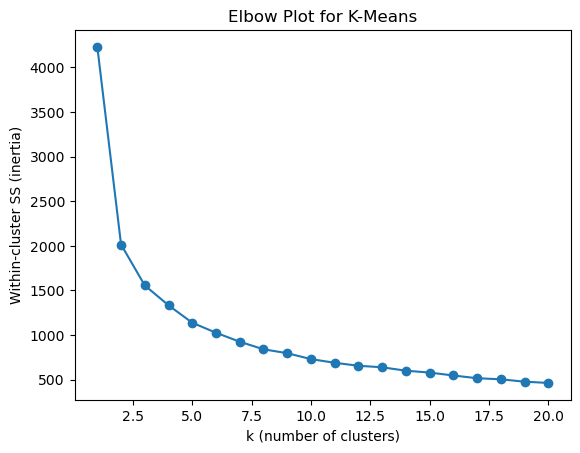

In [98]:
inertias = []
ks = range(1, 21)

for k in ks:
    km_tmp = KMeans(n_clusters=k, n_init=10, max_iter=200, random_state=144)
    km_tmp.fit(X_scaled)
    inertias.append(km_tmp.inertia_)  # inertia = within-cluster SS

plt.figure()
plt.plot(list(ks), inertias, marker="o")
plt.xlabel("k (number of clusters)")
plt.ylabel("Within-cluster SS (inertia)")
plt.title("Elbow Plot for K-Means")
plt.show()


## 4) K-Means clustering with k = 4

Based on the elbow plot, k = 4 is selected as it represents a good balance
between cluster compactness and interpretability.
The K-Means algorithm is now fitted using this value of k, and each student
is assigned to one of the four clusters.

In [99]:
# Fit K-Means with the chosen number of clusters
k = 4

kmeans = KMeans(
    n_clusters=k,
    n_init=10,
    max_iter=200,
    random_state=144
)

# Fit model and get cluster labels
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original dataframe
df["cluster"] = cluster_labels

# Check how many students are in each cluster
df["cluster"].value_counts().sort_index()


cluster
0    142
1    188
2    131
3    244
Name: count, dtype: int64

The table above shows the number of observations assigned to each cluster.
This helps verify that clusters are reasonably balanced and that no cluster
contains an extremely small number of observations.

In [133]:
# Convert scaled data into a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=num_df.columns)

# Add K-Means cluster labels
X_scaled_df["cluster"] = df["cluster"]

# Compute cluster centroids in scaled space
cluster_profile_scaled = (
    X_scaled_df
    .groupby("cluster")
    .mean()
)

cluster_profile_scaled


,Age,Avg_Daily_Usage_Hours,Sleep_Hours_Per_Night,Mental_Health_Score,Conflicts_Over_Social_Media,Addicted_Score
cluster,,,,,,
0,-0.688295,-0.860643,1.073873,1.057182,-0.872842,-1.092441
1,-0.235861,1.189472,-1.122169,-1.120729,1.235019,1.143175
2,1.046014,-0.889740,0.609233,1.052606,-1.174625,-1.093661
3,0.020705,0.062075,-0.087425,-0.316862,0.187032,0.342128


## 5) Interpretation of cluster centers

The cluster centers obtained from K-Means are expressed in scaled units.
To interpret them in a meaningful way (hours, scores, etc.), they are
transformed back into the original variable scale.

In [ ]:
# Transform cluster centers back to original units
cluster_centers_original = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=num_df.columns
)

cluster_centers_original


,Age,Avg_Daily_Usage_Hours,Sleep_Hours_Per_Night,Mental_Health_Score,Conflicts_Over_Social_Media,Addicted_Score
0,19.697183,3.837324,8.078169,7.394366,2.014085,4.704225
1,20.329787,6.413298,5.605319,4.989362,4.031915,8.250000
2,22.122137,3.800763,7.554962,7.389313,1.725191,4.702290
3,20.688525,4.996721,6.770492,5.877049,3.028689,6.979508


To further interpret the clusters, the mean value of each numeric variable
is computed for every cluster. These profiles describe the typical behavior
and outcomes of students within each cluster.

In [101]:
cluster_profile = df.groupby("cluster")[num_df.columns].mean()
cluster_profile

,Age,Avg_Daily_Usage_Hours,Sleep_Hours_Per_Night,Mental_Health_Score,Conflicts_Over_Social_Media,Addicted_Score
cluster,,,,,,
0,19.697183,3.837324,8.078169,7.394366,2.014085,4.704225
1,20.329787,6.413298,5.605319,4.989362,4.031915,8.250000
2,22.122137,3.800763,7.554962,7.389313,1.725191,4.702290
3,20.688525,4.996721,6.770492,5.877049,3.028689,6.979508


## Interpretation of cluster profiles

The clustering analysis identifies four distinct student profiles.

**Cluster 0 – Balanced Users**  
This cluster represents balanced social media users with low daily usage,
high sleep duration, good mental health, and low addiction levels.

**Cluster 1 – High-Risk Addicted Users**  
This cluster shows a high-risk pattern characterized by very high daily usage,
strong addiction scores, reduced sleep, poorer mental health, and frequent
social media–related conflicts.

**Cluster 2 – Low-Usage Mature Users**  
This cluster consists of slightly older students with low social media usage,
good sleep quality, high mental health scores, and the lowest levels of conflict
and addiction.

**Cluster 3 – Moderate-Risk Users**  
This cluster represents moderate users with medium usage and addiction levels,
moderate sleep duration, and noticeable but not extreme negative outcomes.

Overall, the results suggest that higher social media usage and addiction are
associated with poorer sleep, lower mental health, and increased relationship conflicts.

## 6) Visual comparison of clusters

### Average behavior metrics

The bar chart compares the average values of key behavioral and outcome variables
(Age, Avg_Daily_Usage_Hours, Sleep_Hours_Per_Night, Mental_Health_Score,
Conflicts_Over_Social_Media, and Addicted_Score) across the four identified clusters.

In addition, a heatmap is used to visually compare the mean values of each variable
across clusters, allowing differences between cluster profiles to be identified
more easily.

In [102]:
print(df.columns.tolist())


['Student_ID', 'Age', 'Gender', 'Academic_Level', 'Country', 'Avg_Daily_Usage_Hours', 'Most_Used_Platform', 'Affects_Academic_Performance', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 'Relationship_Status', 'Conflicts_Over_Social_Media', 'Addicted_Score', 'cluster']


In [103]:
cluster_name_map = {
    0: "Cluster 1: Low-Usage Mature Users",
    2: "Cluster 2: Balanced Users",
    3: "Cluster 3: Moderate-Risk Users",
    1: "Cluster 4: High-Risk Addicted Users"
}

df["cluster_name"] = df["cluster"].map(cluster_name_map)

# quick check
df[["cluster", "cluster_name"]].drop_duplicates().sort_values("cluster")


,cluster,cluster_name
3,0,Cluster 1: Low-Usage Mature Users
2,1,Cluster 4: High-Risk Addicted Users
1,2,Cluster 2: Balanced Users
0,3,Cluster 3: Moderate-Risk Users


Table for comparison of data, transfromed and raw data

In [104]:
# Variables to compare
metrics = [
    "Age",
    "Avg_Daily_Usage_Hours",
    "Sleep_Hours_Per_Night",
    "Mental_Health_Score",
    "Conflicts_Over_Social_Media",
    "Addicted_Score"
]

# Ensure correct cluster order (low → high risk)
ordered_clusters = [
    "Cluster 1: Low-Usage Mature Users",
    "Cluster 2: Balanced Users",
    "Cluster 3: Moderate-Risk Users",
    "Cluster 4: High-Risk Addicted Users"
]


# Compute cluster means
cluster_means = (
    df.groupby("cluster_name")[metrics]
      .mean()
      .loc[ordered_clusters]
)

# Convert to long format (needed for seaborn barplot)
cluster_means_long = cluster_means.reset_index().melt(
    id_vars="cluster_name",
    value_vars=metrics,
    var_name="Metric",
    value_name="Average"
)

cluster_means_long.head()


,cluster_name,Metric,Average
0,Cluster 1: Low-Usage Mature Users,Age,19.697183
1,Cluster 2: Balanced Users,Age,22.122137
2,Cluster 3: Moderate-Risk Users,Age,20.688525
3,Cluster 4: High-Risk Addicted Users,Age,20.329787
4,Cluster 1: Low-Usage Mature Users,Avg_Daily_Usage_Hours,3.837324


In [152]:
from sklearn.preprocessing import StandardScaler

# --- 1) RAW cluster means (you already have this) ---
cluster_means_raw = cluster_means.copy()   # rows = cluster_name, cols = metrics

# --- 2) Compute SCALED (z-score) version of the same metrics ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[metrics])

scaled_df = pd.DataFrame(X_scaled, columns=metrics)
scaled_df["cluster_name"] = df["cluster_name"]

cluster_means_scaled = (
    scaled_df.groupby("cluster_name")[metrics]
             .mean()
             .loc[ordered_clusters]
)

# --- 3) Combine RAW + SCALED side-by-side per metric (interleaved columns) ---
combined_data = {}
for m in metrics:
    combined_data[(m, "Raw mean")] = cluster_means_raw[m]
    combined_data[(m, "Scaled mean (z-score)")] = cluster_means_scaled[m]

cluster_means_raw_vs_scaled = pd.DataFrame(combined_data)
cluster_means_raw_vs_scaled.columns = pd.MultiIndex.from_tuples(cluster_means_raw_vs_scaled.columns)

# Round for readability
cluster_means_raw_vs_scaled = cluster_means_raw_vs_scaled.round(2)

cluster_means_raw_vs_scaled


Age                        \
                                    Raw mean Scaled mean (z-score)   
cluster_name                                                         
Cluster 1: Low-Usage Mature Users      19.70                  1.05   
Cluster 2: Balanced Users              22.12                 -0.69   
Cluster 3: Moderate-Risk Users         20.69                  0.02   
Cluster 4: High-Risk Addicted Users    20.33                 -0.24   

                                    Avg_Daily_Usage_Hours  \
                                                 Raw mean   
cluster_name                                                
Cluster 1: Low-Usage Mature Users                    3.84   
Cluster 2: Balanced Users                            3.80   
Cluster 3: Moderate-Risk Users                       5.00   
Cluster 4: High-Risk Addicted Users                  6.41   

                                                           \
                                    Scaled mean (z-score)   
cluster_name                                                
Cluster 1: Low-Usage Mature Users                   -0.89   
Cluster 2: Balanced Users                           -0.86   
Cluster 3: Moderate-Risk Users                       0.06   
Cluster 4: High-Risk Addicted Users                  1.19   

                                    Sleep_Hours_Per_Night  \
                                                 Raw mean   
cluster_name                                                
Cluster 1: Low-Usage Mature Users                    8.08   
Cluster 2: Balanced Users                            7.55   
Cluster 3: Moderate-Risk Users                       6.77   
Cluster 4: High-Risk Addicted Users                  5.61   

                                                          Mental_Health_Score  \
                                    Scaled mean (z-score)            Raw mean   
cluster_name                                                                    
Cluster 1: Low-Usage Mature Users                    0.61                7.39   
Cluster 2: Balanced Users                            1.07                7.39   
Cluster 3: Moderate-Risk Users                      -0.09                5.88   
Cluster 4: High-Risk Addicted Users                 -1.12                4.99   

                                                           \
                                    Scaled mean (z-score)   
cluster_name                                                
Cluster 1: Low-Usage Mature Users                    1.05   
Cluster 2: Balanced Users                            1.06   
Cluster 3: Moderate-Risk Users                      -0.32   
Cluster 4: High-Risk Addicted Users                 -1.12   

                                    Conflicts_Over_Social_Media  \
                                                       Raw mean   
cluster_name                                                      
Cluster 1: Low-Usage Mature Users                          2.01   
Cluster 2: Balanced Users                                  1.73   
Cluster 3: Moderate-Risk Users                             3.03   
Cluster 4: High-Risk Addicted Users                        4.03   

                                                          Addicted_Score  \
                                    Scaled mean (z-score)       Raw mean   
cluster_name                                                               
Cluster 1: Low-Usage Mature Users                   -1.17           4.70   
Cluster 2: Balanced Users                           -0.87           4.70   
Cluster 3: Moderate-Risk Users                       0.19           6.98   
Cluster 4: High-Risk Addicted Users                  1.24           8.25   

                                                           
                                    Scaled mean (z-score)  
cluster_name                                               
Cluster 1: Low-Usage Mature Users                   -1.09  
Cluster 2: Balanced Users  

## Heatmap (colors = standardized values, annotations = raw + z-score)

The heatmap colors represent **standardized (z-score) cluster means**, which is the
feature space used by K-Means. Inside each cell, the **raw mean** is shown along
with the corresponding **z-score** in parentheses:
  
**raw value**  
(**z-score**)

This combines interpretability (raw units) with methodological consistency (scaled space).


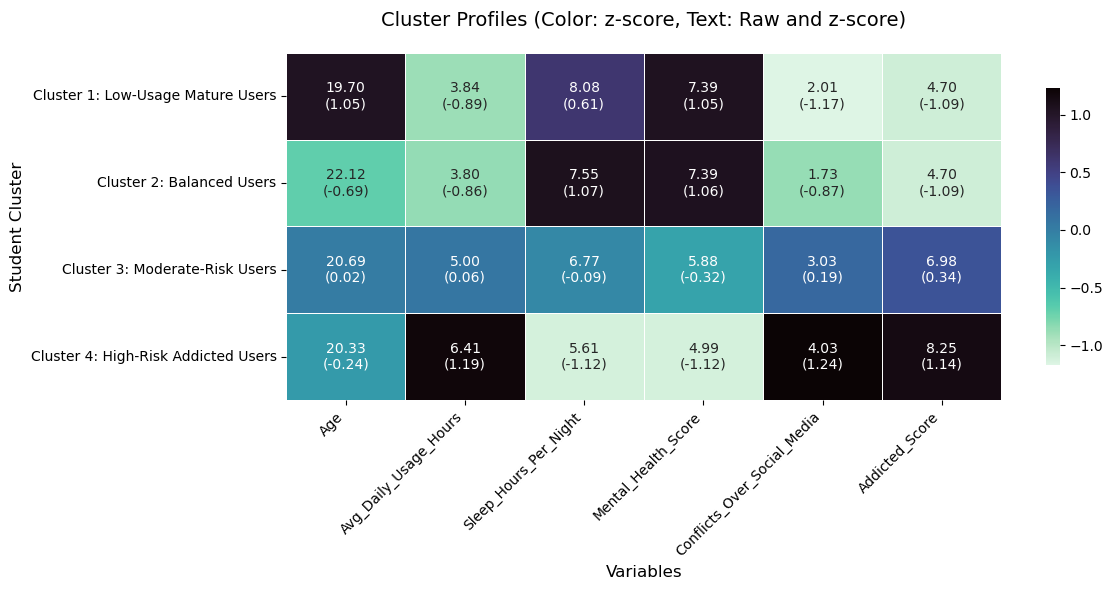

In [154]:
# Assumes you already computed:
# cluster_means_raw (raw means) and cluster_means_scaled (z-score means)
# both indexed by cluster_name in the same ordered_clusters order.

# 1) Ensure correct row/column order
raw = cluster_means_raw.loc[ordered_clusters, metrics]
z   = cluster_means_scaled.loc[ordered_clusters, metrics]

# 2) Build annotation strings: raw on top, z-score in parentheses below
annot = raw.copy()
for c in metrics:
    annot[c] = raw[c].map(lambda v: f"{v:.2f}") + "\n(" + z[c].map(lambda v: f"{v:.2f}") + ")"

# 3) Plot heatmap: use z-scores for color, but annotate with raw + z
plt.figure(figsize=(12, 6))
sns.heatmap(
    z,                      # <-- colors based on standardized values
    annot=annot,            # <-- text shows raw + z
    fmt="",                 # <-- important: strings, so no numeric formatting
    cmap="mako_r",          # inverted: bright=low, dark=high (as you wanted)
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Cluster Profiles (Color: z-score, Text: Raw and z-score)", fontsize=14, pad=20)
plt.ylabel("Student Cluster", fontsize=12)
plt.xlabel("Variables", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [155]:
# --- Build plotting DataFrame with raw + z-score ---
plot_data = []

for cluster in ordered_clusters:
    for metric in metrics:
        plot_data.append({
            "cluster_name": cluster,
            "Metric": metric,
            "Average": cluster_means_raw.loc[cluster, metric],     # bar height
            "z_score": cluster_means_scaled.loc[cluster, metric]   # annotation
        })

plot_data = pd.DataFrame(plot_data)
plot_data.head()


,cluster_name,Metric,Average,z_score
0,Cluster 1: Low-Usage Mature Users,Age,19.697183,1.046014
1,Cluster 1: Low-Usage Mature Users,Avg_Daily_Usage_Hours,3.837324,-0.889740
2,Cluster 1: Low-Usage Mature Users,Sleep_Hours_Per_Night,8.078169,0.609233
3,Cluster 1: Low-Usage Mature Users,Mental_Health_Score,7.394366,1.052606
4,Cluster 1: Low-Usage Mature Users,Conflicts_Over_Social_Media,2.014085,-1.174625


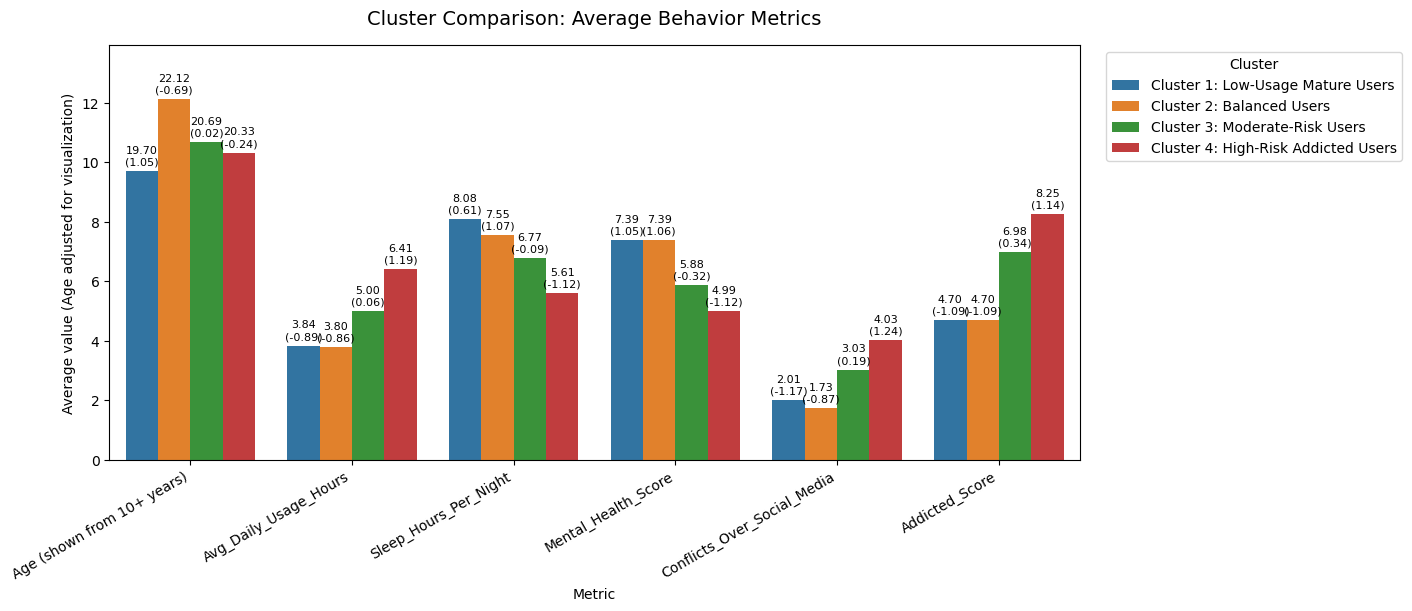

In [160]:
plt.figure(figsize=(14, 6), constrained_layout=True)

ax = sns.barplot(
    data=plot_data,
    x="Metric",
    y="Average",
    hue="cluster_name"
)

plt.title("Cluster Comparison: Average Behavior Metrics", fontsize=14, pad=15)
plt.xlabel("Metric")
plt.ylabel("Average value (Age adjusted for visualization)")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")

# Give extra space for annotations above bars
plt.margins(y=0.15)

# Annotations (unchanged)
for bar, (_, row) in zip(ax.patches, plot_data.iterrows()):
    height = bar.get_height()
    ax.annotate(
        f"{row['raw_value']:.2f}\n({row['z_score']:.2f})",
        (bar.get_x() + bar.get_width() / 2, height),
        ha="center",
        va="bottom",
        fontsize=8,
        xytext=(0, 3),
        textcoords="offset points"
    )

plt.show()


## Results: Cluster profiles

Figure Above presents the mean profiles of the four clusters ordered from low to high risk.
Clear differences between clusters are observed across social media usage, addiction,
sleep duration, mental health, and conflict frequency.

Low-risk clusters show lower usage and addiction levels combined with better sleep
and mental health, while high-risk clusters are characterized by intensive usage,
high addiction scores, reduced sleep, poorer mental health, and more frequent conflicts.


## Interpretation

The bar chart highlights clear differences between the identified clusters.
The high-risk addicted group shows the highest daily usage and addiction scores,
while also sleeping the least and reporting the lowest mental health levels.
This consistent pattern reinforces the interpretation of this cluster as
exhibiting problematic social media behavior.

The cluster ordering reveals a consistent gradient from healthy to problematic
social media behavior. As average daily usage and addiction scores increase,
sleep duration and mental health decline, while relationship conflicts increase.

This pattern suggests that social media addiction is not an isolated behavior,
but is associated with multiple negative well-being outcomes.




## Limitations

This analysis is based on cross-sectional survey data and therefore identifies
associations rather than causal relationships. In addition, clustering results
depend on the selected variables and the chosen number of clusters.
Future research could validate these segments using longitudinal data.


## Conclusion

Using K-Means clustering, four distinct student profiles were identified based on
social media usage and related outcomes. The results indicate a clear relationship
between higher usage intensity and addiction with poorer sleep, mental health,
and increased relationship conflicts.

These findings highlight the importance of considering behavioral patterns rather
than single variables when studying social media use among students.


## 7) Hierarchical clustering (Ward linkage)

In addition to K-Means, hierarchical clustering is applied to group students based on similarity.
Ward’s method is used because it tends to produce compact, well-separated clusters and is comparable
to minimizing within-cluster variance.


In [111]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


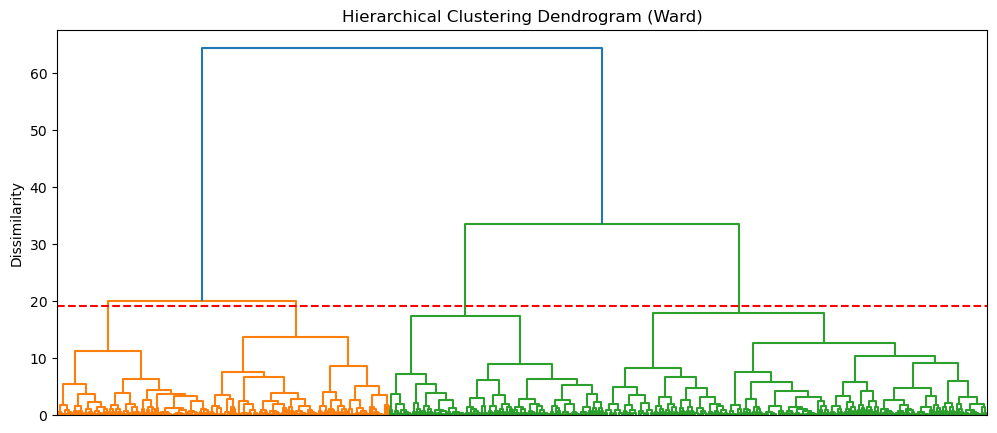

In [112]:
plt.figure(figsize=(12, 5))
dendrogram(Z, no_labels=True)

# Horizontal cut line (choose around 35)
plt.axhline(y=19, color='red', linestyle='--')

plt.title("Hierarchical Clustering Dendrogram (Ward)")
plt.ylabel("Dissimilarity")
plt.show()


### Cutting the dendrogram into k clusters

To compare with K-Means, the dendrogram is cut into **k = 4** clusters.


In [ ]:
k = 4

# Create flat clusters from the hierarchy (labels are 1..k)
hc_labels = fcluster(Z, t=k, criterion="maxclust")

# Store them in the dataframe
df["hc_cluster"] = hc_labels

# Cluster sizes
df["hc_cluster"].value_counts().sort_index()


hc_cluster
1    116
2    136
3    163
4    290
Name: count, dtype: int64

Hierarchical clustering delivers the same result as K-means clustering. 
4 Clusters

## Additional analysis: Sunlight exposure and social media addiction

**Research question:**  
Do students living in countries with higher average sunlight hours show lower
social media addiction scores than students living in countries with less sunlight?

To explore this question, country-level average addiction scores are combined
with average annual sunshine hours and visualized using a world heat map.


In [114]:
# Load sunshine data
sunshine_df = pd.read_csv("Sunshine_hours_world.csv")

# Check it loaded correctly
display(sunshine_df.head())
print(sunshine_df.columns)


,Country,Avg sun hrs per year
0,Namibia,3737.50
1,Egypt,3710.68
2,Sudan,3559.55
3,United ArabEmirates,3508.70
4,Oman,3493.30


Index(['Country', 'Avg sun hrs per year'], dtype='object')


## Global distribution of sunshine hours

This map visualizes the average annual sunshine hours by country using
global climate data. It provides contextual background for the analysis
of environmental factors such as sunlight exposure.


In [115]:
fig = px.choropleth(
    sunshine_df,
    locations="Country",
    locationmode="country names",
    color=sun_col,
    hover_name="Country",
    color_continuous_scale="YlOrRd",
    title="Average Annual Sunshine Hours by Country"
)

fig.show()


In [116]:
# Check how USA is written in both datasets
print(sorted(df["Country"].unique()))
print(sorted(sunshine_df["Country"].unique()))


['Afghanistan', 'Albania', 'Andorra', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Bhutan', 'Bolivia', 'Bosnia', 'Brazil', 'Bulgaria', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Ecuador', 'Egypt', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Latvia', 'Lebanon', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malaysia', 'Maldives', 'Malta', 'Mexico', 'Moldova', 'Monaco', 'Montenegro', 'Morocco', 'Nepal', 'Netherlands', 'New Zealand', 'Nigeria', 'North Macedonia', 'Norway', 'Oman', 'Pakistan', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia', 'San Marino', 'Serbia', 'Singapore', 'Slovakia', 'Slovenia',

In [117]:
# Create a mapping for known country name differences
country_name_fixes = {
    "USA": "United States of America",
    "United States": "United States of America",
    "UK": "United Kingdom",
    "South Korea": "Korea, Republic of",
    "Russia": "Russian Federation"
}

# Apply mapping to student dataset
df["Country"] = df["Country"].replace(country_name_fixes)

# Apply mapping to sunshine dataset (optional safety)
sunshine_df["Country"] = sunshine_df["Country"].replace(country_name_fixes)


In [118]:
# Aggregate addiction score by country
addiction_by_country = (
    df.groupby("Country")["Addicted_Score"]
      .mean()
      .reset_index()
)

# Merge with sunshine data
merged_country_df = pd.merge(
    addiction_by_country,
    sunshine_df,
    on="Country",
    how="inner"
)

display(merged_country_df.head())
print("Number of countries used:", merged_country_df.shape[0])


,Country,Addicted_Score,Avg sun hrs per year
0,Afghanistan,5.000000,3175.100000
1,Albania,7.000000,2544.000000
2,Argentina,8.000000,2220.300000
3,Armenia,9.000000,2474.000000
4,Australia,5.285714,2975.426667


Number of countries used: 85


In [119]:
import plotly.express as px

fig = px.choropleth(
    merged_country_df,
    locations="Country",
    locationmode="country names",
    color="Addicted_Score",
    hover_name="Country",
    color_continuous_scale="RdYlBu_r",
    title="Average Social Media Addiction Score by Country"
)

fig.show()


In [120]:
# --- find the sunshine column automatically ---
sun_cols = [c for c in merged_country_df.columns if "sun" in c.lower()]
print("Possible sunshine columns:", sun_cols)

# choose the first match (adjust if you see multiple and want a specific one)
sun_col = sun_cols[0] if sun_cols else None
print("Using sunshine column:", sun_col)

# --- make sure sunshine is numeric (remove commas/units if needed) ---
merged_country_df[sun_col] = (
    merged_country_df[sun_col]
    .astype(str)
    .str.replace(",", "", regex=False)          # "2,500" -> "2500"
    .str.extract(r"([-+]?\d*\.?\d+)")[0]        # pull out the number only
    .astype(float)
)

# drop rows where sunshine is missing after conversion
merged_country_df = merged_country_df.dropna(subset=[sun_col])

merged_country_df[[ "Country", "Addicted_Score", sun_col ]].head()


Possible sunshine columns: ['Avg sun hrs per year']
Using sunshine column: Avg sun hrs per year


,Country,Addicted_Score,Avg sun hrs per year
0,Afghanistan,5.000000,3175.100000
1,Albania,7.000000,2544.000000
2,Argentina,8.000000,2220.300000
3,Armenia,9.000000,2474.000000
4,Australia,5.285714,2975.426667


In [121]:
import plotly.express as px

fig2 = px.choropleth(
    merged_country_df,
    locations="Country",
    locationmode="country names",
    color=sun_col,
    hover_name="Country",
    hover_data={"Addicted_Score": True, sun_col: True},
    color_continuous_scale="YlOrRd",
    title="Average Annual Sunshine Hours by Country (Standardized Country Names)"
)

fig2.show()


## Hierarchical clustering of countries based on sunlight and addiction

To identify groups of countries with similar environmental and behavioral
characteristics, hierarchical clustering is applied at the country level.
Countries are clustered based on their average annual sunshine hours and
average student social media addiction scores.


In [122]:
print(merged_country_df.columns.tolist())


['Country', 'Addicted_Score', 'Avg sun hrs per year']


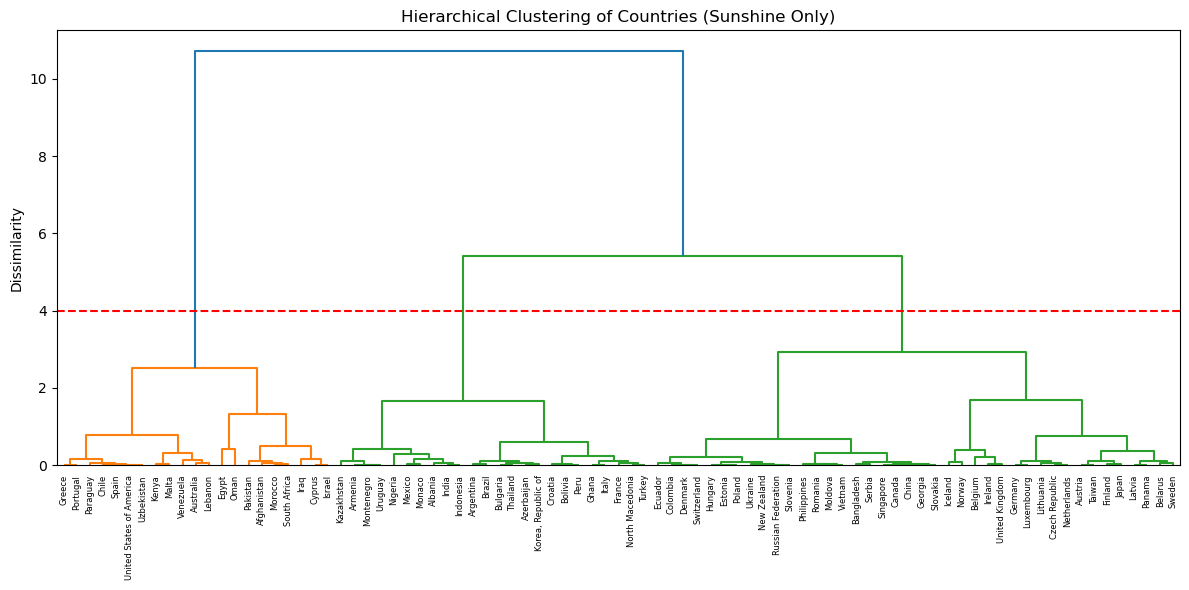

In [123]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Select ONLY sunshine for clustering (country-level)
country_features = merged_country_df[["Avg sun hrs per year"]].copy()

# Ensure sunshine column is numeric (in case it was read as text)
country_features["Avg sun hrs per year"] = (
    country_features["Avg sun hrs per year"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .str.extract(r"([-+]?\d*\.?\d+)")[0]
    .astype(float)
)

# Scale sunshine (still good practice for clustering)
scaler_country = StandardScaler()
X_country_scaled = scaler_country.fit_transform(country_features)

# Hierarchical clustering (Ward) using ONLY sunshine
Z_country = linkage(X_country_scaled, method="ward")

# Dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z_country, labels=merged_country_df["Country"].values, leaf_rotation=90)

# Horizontal cut line (choose around 35)
plt.axhline(y=4, color='red', linestyle='--')

plt.title("Hierarchical Clustering of Countries (Sunshine Only)")
plt.ylabel("Dissimilarity")
plt.tight_layout()
plt.show()




## Country clusters (k = 3)

Based on the dendrogram, the countries are grouped into **3 clusters** using a cut
just below the largest jump in dissimilarity. The resulting clusters are analyzed
by comparing their average sunshine hours and addiction scores.


| Cluster   | Meaningful name                 | Interpretation                                        |
| --------- | ------------------------------- | ----------------------------------------------------- |
| Cluster 1 | **High-Sunlight Countries**     | Many annual sunshine hours |
| Cluster 2 | **Moderate-Sunlight Countries** | Average sunshine                 |
| Cluster 3 | **Low-Sunlight Countries**      | Few sunshine hours       |


In [124]:
k_country = 3

merged_country_df["country_cluster"] = fcluster(
    Z_country,
    t=k_country,
    criterion="maxclust"
)
# Assign meaningful names to country clusters
country_cluster_names = {
    1: "High-Sunlight Countries",
    2: "Moderate-Sunlight Countries",
    3: "Low-Sunlight Countries"
}

merged_country_df["country_cluster_name"] = (
    merged_country_df["country_cluster"].map(country_cluster_names)
)

# Sanity check
merged_country_df[["Country", "country_cluster", "country_cluster_name"]].head()
country_cluster_summary_named = (
    merged_country_df
    .groupby("country_cluster_name")
    .agg(
        n_countries=("Country", "count"),
        mean_sunshine=("Avg sun hrs per year", "mean"),
        mean_addiction=("Addicted_Score", "mean")
    )
)

country_cluster_summary_named


,n_countries,mean_sunshine,mean_addiction
country_cluster_name,,,
High-Sunlight Countries,21,3058.139533,6.076336
Low-Sunlight Countries,40,1857.425840,6.187052
Moderate-Sunlight Countries,24,2378.128409,6.779725


## Hypothesis testing: Sunshine exposure and social media addiction
**Research question:**  
Do students living in countries with lower average annual sunshine hours exhibit
higher average social media addiction scores than students living in countries
with higher sunlight exposure?

This analysis tests whether countries with lower average annual sunshine hours
exhibit higher average social media addiction scores compared to countries with
higher sunlight exposure.



- **H₀ (Null hypothesis):**  
  There is no difference in average social media addiction scores between
  countries with low and high sunshine exposure.

- **H₁ (Alternative hypothesis):**  
  Countries with lower sunshine exposure have higher average social media
  addiction scores than countries with higher sunshine exposure.


## Statistical test selection and rationale

Countries were clustered exclusively based on average annual sunshine hours.
Social media addiction scores were **not** used in the clustering process and are
therefore suitable as an outcome variable for hypothesis testing.

- **Outcome variable:**  
  `Addicted_Score` (continuous)

- **Grouping variable:**  
  Sunshine-based country clusters (categorical, k = 3)

- **Sample size:**  
  Relatively small number of observations per group (countries)


In [125]:
# Mean addiction score per sunshine-based cluster
merged_country_df.groupby("country_cluster_name")["Addicted_Score"].mean()


country_cluster_name
High-Sunlight Countries        6.076336
Low-Sunlight Countries         6.187052
Moderate-Sunlight Countries    6.779725
Name: Addicted_Score, dtype: float64

### Chosen statistical approach

First, a **one-way ANOVA** was applied to compare the average social media addiction
scores across the sunshine-based country clusters. This global test assesses
whether at least one cluster differs significantly from the others in terms of
addiction levels.ectional hypothesis while avoiding circularity in the analysis.

In [126]:
from scipy.stats import f_oneway

# Extract addiction scores by cluster
groups = [
    merged_country_df.loc[
        merged_country_df["country_cluster_name"] == name,
        "Addicted_Score"
    ]
    for name in merged_country_df["country_cluster_name"].unique()
]

F_stat, p_value = f_oneway(*groups)

print(f"ANOVA F-statistic = {F_stat:.3f}")
print(f"ANOVA p-value     = {p_value:.4f}")


ANOVA F-statistic = 1.442
ANOVA p-value     = 0.2424


Second, to directly address the research hypothesis, a **pairwise comparison**
between **Low-Sunlight** and **High-Sunlight** countries was performed using an
independent samples t-test. This targeted test evaluates whether countries with
less sunlight exhibit higher addiction scores than countries with more sunlight.

Together, these tests allow both an overall assessment of group differences and
a focused evaluation of the hypothesized directional relationship.

In [127]:
from scipy.stats import ttest_ind

low_sun = merged_country_df.loc[
    merged_country_df["country_cluster_name"] == "Low-Sunlight Countries",
    "Addicted_Score"
]

high_sun = merged_country_df.loc[
    merged_country_df["country_cluster_name"] == "High-Sunlight Countries",
    "Addicted_Score"
]

t_stat, p_val = ttest_ind(low_sun, high_sun, equal_var=False)

print(f"T-statistic = {t_stat:.3f}")
print(f"P-value     = {p_val:.4f}")


T-statistic = 0.251
P-value     = 0.8028


## Significance level

For all statistical hypothesis tests, a significance level of  
**α = 0.05** is used.  
P-values below this threshold are considered statistically significant.


## 📊 Interpretation of hypothesis test results (α = 0.05)

Using a significance level of **α = 0.05**, the one-way ANOVA comparing average
social media addiction scores across sunshine-based country clusters yields a
p-value of **0.2424**. ❌ Since this value is greater than α, the null hypothesis
cannot be rejected, indicating **no statistically significant differences**
between the clusters.

Similarly, the independent samples t-test comparing **🌥️ Low-Sunlight** and
**☀️ High-Sunlight** countries results in a p-value of **0.8028**, which also
exceeds α. ❌ Therefore, there is **no statistical evidence** to support the
hypothesis that countries with lower average sunshine exposure exhibit higher
student social media addiction scores.
